real space ko grid ko size =((128, 128), (128, 128))
fourier space ko grid ko size =((128, 128), (128, 128))
pp2 shape: (128, 128), qq2 shape: (128, 128)
<class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
next output ko size =Traced<ShapedArray(float32[128,128,1])>with<DynamicJaxprTrace(level=5/0)>
u_k1 shape= (128, 128, 1)
s_hat shape = (128, 128, 1)
Denominator shape: (128, 128, 1)
v_hat shape: (128, 128, 1)
u_gt shape: (128, 128, 1)
Gradients: [(Traced<ShapedArray(float32[1,32])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[32])>with<DynamicJaxprTrace(level=1/0)>), (), (Traced<ShapedArray(float32[32,128])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=1/0)>), (), (Traced<ShapedArray(float32[128,1])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>)]
Iteration 0, Loss: 154964048.0
Iteration 1, Loss: 6.293193340041036e+18
Iteration 2, Loss: 9383295582208

C:\Users\Manju\AppData\Local\Temp\ipykernel_11468\4043456174.py:246: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))


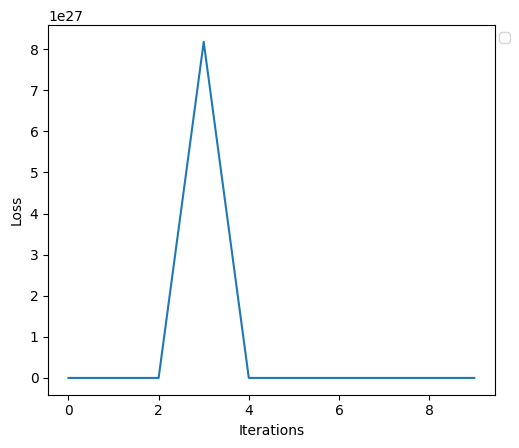

In [76]:
import jax
import jax.numpy as jnp
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import os
from jax import random, grad, vmap, jit,jacfwd,jacrev, vjp
from jax.example_libraries import optimizers
from jax.nn import relu, sigmoid, swish, elu, silu , selu
from jax import lax
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib import font_manager
from matplotlib import font_manager
from scipy.interpolate import griddata
import matplotlib.colors as colors
from scipy.interpolate import interp2d
from matplotlib.cm import tab20
import jax.scipy as sp
import os
import time
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.numpy.linalg import inv, det  # Make sure det is imported here
import jaxopt
import optax
from jax.example_libraries.optimizers import optimizer, make_schedule, exponential_decay
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.nn.initializers import glorot_uniform, normal, glorot_normal
import timeit
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from spifol_archs import MLP, modified_MLP, FNOBlock2D, Permute, Dense, complex_adam
from jax.example_libraries import optimizers 



# SPiFOL for linear elasticity
class SPiFOL:
    def __init__(self, N,  fno_layers, lr,  norm_par, xx, yy, cahn, pp2, qq2, dt, epochs, hx, hy,u):
        self.N = N
        self.lr = lr
        self.norm_par = norm_par
        self.xx = xx
        self.yy = yy
        self.pp2 = pp2
        self.qq2 = qq2
        self.cahn = cahn
        self.dt = dt
        self.epochs = epochs
        self.hx =hx
        self.hy = hy
        self.u = u
        print(f"pp2 shape: {self.pp2.shape}, qq2 shape: {self.qq2.shape}")


        # Initialize the network based on architecture type
        
        
        self.N_init, self.N_apply = serial(*fno_layers)
       
        _, params = self.N_init(random.PRNGKey(1234), (1, 128, 128, 1))

        self.params = params
        

        # Create an exponential decay learning rate schedule
        schedule = optimizers.exponential_decay(lr, decay_steps=2000, decay_rate=0.99)

        # Initialize the normal Adam optimizer
        self.opt_init,self.opt_update, self.get_params = optimizers.adam(step_size=schedule)

        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9
            )
        )
        self.opt_state = self.opt_init(self.params)

        # Logging losses
        self.total_loss_log = []

    

        # Initialize optimizer state
       
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()
        
       
        self.sigma = []

 
    @partial(jit, static_argnums=(0,))
    def fft2(self, x):
        """Applies a 2D FFT over the first two dimensions of the input array x."""
        return fftn(x, axes=(0, 1))

    @partial(jit, static_argnums=(0,))
    def ifft2(self, x):
        """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
        return ifftn(x, axes=(0, 1))

    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, input_data):
        input_FNO = input_data
        # input_FNO = jnp.stack([input_data], axis=-1)  # Combine with spatial grid
        next_output = self.N_apply(params, input_FNO)  # Apply the FNO network
        print(f'next output ko size ={next_output}')
        # normalized_output = next_output / self.norm_par  # Normalize the output
        
        return next_output


    @partial(jit, static_argnums=(0,))
    def physical_loss(self, params, input_data):
        u = jnp.real(input_data) 
        u_k1 = self.operator_net(params, u)
        print(f'u_k1 shape= {u_k1.shape}')
        s_hat = jfft.fft2(self.cahn * u - self.dt*(u**3 - 3* u))
        print(f's_hat shape = {s_hat.shape}')
        denominator = (self.cahn + self.dt * (2 + self.cahn * (self.pp2 + self.qq2)))[..., None]
        print(f"Denominator shape: {denominator.shape}")
        v_hat = s_hat / denominator
        print(f"v_hat shape: {v_hat.shape}")

        # Compute inverse FFT for ground truth
        u_gt = jnp.fft.ifft2(v_hat).real  # Extract real part
        print(f"u_gt shape: {u_gt.shape}")

        # Compute physical loss
        # loss = jnp.mean(jnp.abs(u_k1 - u_gt) ** 2)

        distance_loss = jnp.mean(jnp.abs(u_k1 - u_gt)**2)
        energy_loss = self.compute_energy(u,pp2,qq2,hx,hy,N,cahn)

        Total_Loss = distance_loss + energy_loss


        # weight_decay = 1e-4
        # loss = jnp.mean(jnp.abs(u_k1 - u_gt)**2) + weight_decay * jnp.sum(jnp.square(params))

        # print(f"Physical loss: {loss}")



        # plt.imshow(jnp.abs((u_k1[..., 0])), cmap='viridis')
        # plt.title('Predicted')
        # plt.colorbar()
        # plt.show()

        # plt.imshow(jnp.abs((u_gt[..., 0])), cmap='viridis')
        # plt.title('Ground Truth')
        # plt.colorbar()
        # plt.show()



        return Total_Loss
    
       
       
    

    
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, input_data):
        params = self.get_params(opt_state)
        print(type(input_data))  # To check if it's a JAX array

        # g = grad(self.physical_loss)(params, input_data)

        # gradients = grad(self.physical_loss)(params, input_data)
        # gradients = jax.tree_map(lambda x: jnp.clip(x, -1.0, 1.0), gradients)

        gradients = grad(self.physical_loss)(params, input_data)
        print(f"Gradients: {gradients}")



        return self.opt_update(i, gradients, opt_state)
    
    
    def train(self, input_data):

        for it in range(self.epochs):
            self.opt_state = self.step(it, self.opt_state, input_data)

            # Logger (log the loss every 100 iterations)
            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss = self.physical_loss(params, input_data)
                self.total_loss_log.append(loss)
                print(f"Iteration {it}, Loss: {loss}")
                
                
    
                
            

    @partial(jit, static_argnums=(0,))
    def pred(self, params, input_data):
        evolved_condt = self.operator_net(params, input_data)
        return evolved_condt


    def plot_losses(self):
        # Convert loss array and jax numpy array for plotting
            total_loss = jnp.asarray(self.total_loss_log)
    

         #print(x_axis)
        # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            # plt.semilogy(epochs, total_loss, label="Train", c='red')
            plt.plot(self.total_loss_log)
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            # plt.savefig(save_as + "Total_loss.png")

 


    # Define the free energy potential F(u)
    def F(self, u):
        return 0.25 * (u**2 - 1)**2

    # Compute the energy dissipation
    def compute_energy(self,u,pp2,qq2,hx,hy,N,cahn):
        # Fourier transform of u
        phi_hat = jnp.fft.fft2(u)

    

        # Spectral derivatives
        phi_hat_x = 1j * pp2 * phi_hat
        phi_hat_y = 1j * qq2 * phi_hat

        # Parseval's identity for energy computation
        gradient_squared = jnp.abs(phi_hat_x)**2 + jnp.abs(phi_hat_y)**2

        # Energy in Fourier space
        energy = (
            jnp.sum(self.F(u)) / cahn * hx * hy +
            (hx * hy / (N * N)) * jnp.sum(gradient_squared) / 2
        )

        return energy

        # # Test the function
        # phi = jnp.tanh(jnp.linspace(-2, 2, Nx).reshape(-1, 1) + jnp.linspace(-2, 2, Ny))
        # energy = compute_energy(phi)
        # print("Energy:", energy)

    





# difinning the no of grid points in x, y and z
N = 128 # number of grid point


# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / N #spatial step size in coordinate x
hy = Ly / N #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 20 #number of snapshots

# Define the grid points in x and y direction
x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,N) 
y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,N) 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x, y) 
print(f'real space ko grid ko size ={xx.shape,yy.shape}')

# defining parameters for the Allen-Cahn equation
epsillon = 0.05 #small parameter
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
input_data =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))
input_data = jnp.stack([input_data], axis=-1)


# defining the wavevector in x and y direction , which is in fourier space 
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, N//2), 2 * jnp.pi / Lx * jnp.arange(-N//2  , 0)]) 
q= jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, N//2), 2 * jnp.pi / Ly * jnp.arange(-N//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 
q2 = q**2

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
print(f'fourier space ko grid ko size ={pp2.shape,qq2.shape}')


fno_layers = [
    Dense(32),
    Gelu,
    Dense(128),
    Gelu,
    Dense(1)
]


epochs = 100
N=128 
layers=None
lr=0.0001
activation=jax.nn.relu # here its not used
norm_par=2000.0




model_fno = SPiFOL(
    N, 
    fno_layers,
    lr,
    norm_par,
    xx,
    yy,
    cahn,
    pp2,
    qq2,
    dt,
    epochs,
    hx,
    hy,              
    input_data

)


# training

model_fno.train(input_data)
model_fno.plot_losses()





